In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = '/dlabdata1/turkish_wiki'

# Newcomers

In [25]:
all_registrations = pd.read_csv(f'{DATA_PATH}/processed_data/all_registrations.csv')

In [26]:
all_registrations.columns = ['date', 'user_id']

In [27]:
all_registrations['date'] = pd.to_datetime(all_registrations['date'],   utc = True)

In [28]:
all_registrations = all_registrations.set_index('date')

In [29]:
yearly_registrations = all_registrations.groupby(pd.Grouper(freq= 'Y')).count().reset_index()
yearly_registrations.date = yearly_registrations.date.dt.strftime("%Y")
yearly_registrations.columns = ['Year', 'New Users']

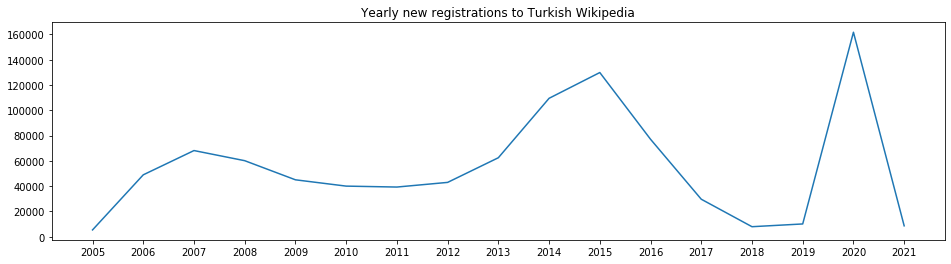

In [30]:
plt.figure(figsize=(16,4))
plt.title("Yearly new registrations to Turkish Wikipedia")
plt.plot(yearly_registrations['Year'], yearly_registrations['New Users'])
plt.show()

New registrations was already does from its' peak in 2015 by the year 2016. The ban on 2017 decreased this number to the days of the early internet. A huge recovery is seen in 2020 after that the ban was lifted

In [31]:
block_dates = [pd.to_datetime('2017-04-29', utc = True), pd.to_datetime('2020-01-15', utc = True)]

In [32]:
daily_registrations = all_registrations.groupby(pd.Grouper(freq= 'D')).count().reset_index()
daily_registrations.columns = ['Day', 'New Users']

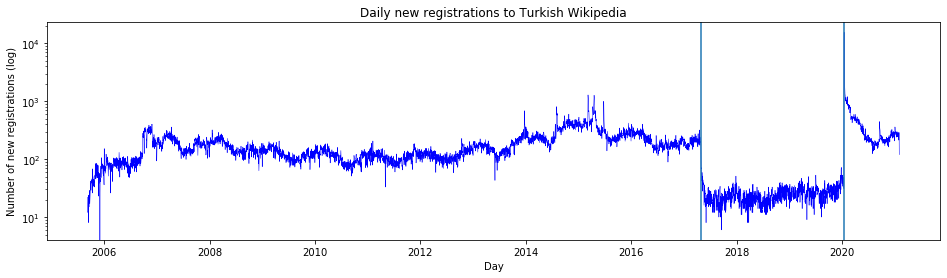

In [33]:
plt.figure(figsize=(16,4))
plt.title("Daily new registrations to Turkish Wikipedia")
plt.plot(daily_registrations['Day'].values, daily_registrations['New Users'], color='blue', lw=0.5)
plt.ylabel("Number of new registrations (log)")
plt.xlabel("Day")
for date in block_dates:
    plt.axvline(date)
plt.yscale('log')
plt.show()

A closer look on the daily registrations in log scale highlights the severity of the block. A very sharp decrease and a very sharp increase is observed at the days where Wikipedia got blocked/unblocked. The arrival of new users doesn't seem to increase much after the initial shock of the block. After the sharp increase of new users at the day of the unblock, new users registrations seem to reach historical levels, stablizing at the pre-block levels after a slow decrease.

In [34]:
daily_registrations.sort_values('New Users', ascending= False).head()

,Day,New Users
5243,2020-01-16 00:00:00+00:00,15531
5242,2020-01-15 00:00:00+00:00,9230
5244,2020-01-17 00:00:00+00:00,4504
5245,2020-01-18 00:00:00+00:00,2485
5246,2020-01-19 00:00:00+00:00,2021


In [35]:
daily_registrations[daily_registrations['Day'] < block_dates[0]].sort_values('New Users', ascending= False).head()

,Day,New Users
3468,2015-03-08 00:00:00+00:00,1285
3510,2015-04-19 00:00:00+00:00,1269
3469,2015-03-09 00:00:00+00:00,1180
3511,2015-04-20 00:00:00+00:00,1166
3509,2015-04-18 00:00:00+00:00,1137


In [36]:
blocked_days = (block_dates[1] - block_dates[0]).days

In [37]:
# Have symmetric before and after block intervals
days_after_block = (daily_registrations['Day'].max()-block_dates[1]).days
daily_registrations = daily_registrations[daily_registrations['Day'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

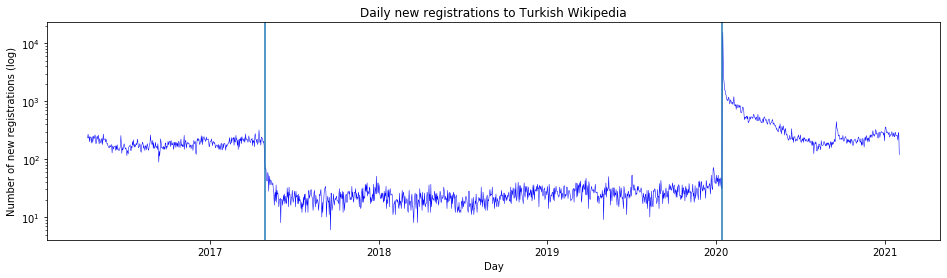

In [38]:
plt.figure(figsize=(16,4))
plt.title("Daily new registrations to Turkish Wikipedia")
plt.plot(daily_registrations['Day'].values, daily_registrations['New Users'], color='blue', lw=0.5)
plt.ylabel("Number of new registrations (log)")
plt.xlabel("Day")
for date in block_dates:
    plt.axvline(date)
plt.yscale('log')
plt.show()

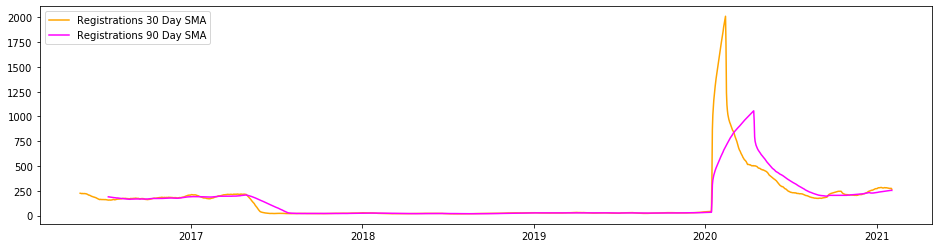

In [39]:
plt.figure(figsize=(16,4))
rolling_mean = daily_registrations['New Users'].rolling(window=30).mean()
rolling_mean2 = daily_registrations['New Users'].rolling(window=90).mean()
plt.plot(daily_registrations['Day'].values, rolling_mean, label='Registrations 30 Day SMA', color='orange')
plt.plot(daily_registrations['Day'].values, rolling_mean2, label='Registrations 90 Day SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

In [40]:
daily_registrations['period'] = daily_registrations.apply(lambda row: 'pre-block' if row['Day'] < block_dates[0] else 'block' if not row['Day'] >= block_dates[1] else 'after-block', axis=1)

In [41]:
groups = daily_registrations.groupby('period')
periods = pd.concat([pd.DataFrame(x[1]['New Users'].values) for x in groups], axis=1)
periods = pd.DataFrame(periods)
periods.columns = range(1,4)

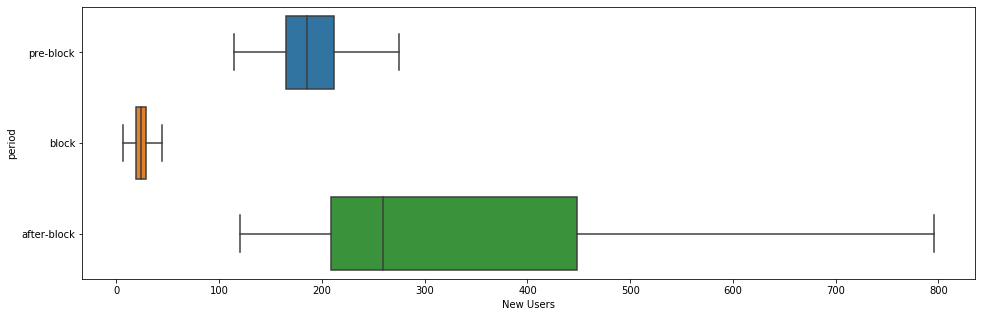

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
plt.xlabel('Daily New Users')
ax = sns.boxplot(y="period", x="New Users", data=daily_registrations,  showfliers=False)

### Hour of the day of registrations

In [43]:
all_registrations = all_registrations.reset_index()

In [44]:
all_registrations['Hour'] = all_registrations.date.dt.strftime("%H")

In [45]:
hourly_registrations = all_registrations[all_registrations['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

In [46]:
hourly_registrations['period'] = hourly_registrations.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
hourly_registrations = hourly_registrations.groupby(['period', 'Hour']).count()[['date']]

In [48]:
hourly_registrations.columns = ['count']

In [49]:
hourly_registrations['percent'] =  hourly_registrations['count'].div(hourly_registrations['count'].sum(level=0),level=0)

In [50]:
hourly_registrations = hourly_registrations.reset_index()

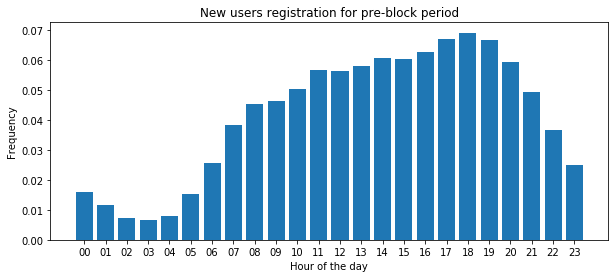

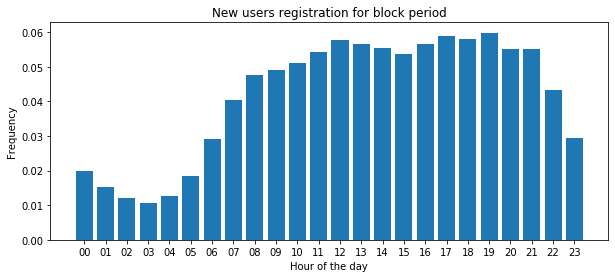

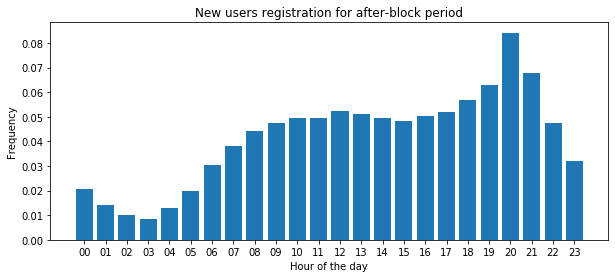

In [51]:
for period in ['pre-block', 'block', 'after-block']:
    plt.figure(figsize=(10,4))
    plt.bar(hourly_registrations[hourly_registrations.period == period]['Hour'],hourly_registrations[hourly_registrations.period == period]['percent'], label="Data 1")

    # The following commands add labels to our figure.
    plt.xlabel('Hour of the day')
    plt.ylabel('Frequency')
    plt.title(f'New users registration for {period} period')

    plt.show()

No significant shift in registration hours is observed. We must dig deeper in the data to know if the new registrations came from Turkey or outside of Turkey. Detecting if editors come from Turkey or outside using this method can be hard as most of turkish diaspora outside of Turkey lives in Europe, so the time difference is not significant.

# Edits

In [52]:
edits = pd.read_csv(f'{DATA_PATH}/processed_data/edits.csv')

In [53]:
edits

,date,page_id,user_kind,event_user_id,revision_text_bytes
0,2002-12-05,5,account,1,24
1,2002-12-05,2740662,anonymous,2,1819
2,2002-12-13,2740662,anonymous,2,1781
3,2002-12-16,2740662,anonymous,2,4766
4,2002-12-17,2740662,anonymous,1,4310
...,...,...,...,...,...
12753708,2021-02-01,2908802,account,1,801
12753709,2021-02-01,2908803,account,2,1644
12753710,2021-02-01,2908804,account,2,1644
12753711,2021-02-01,2908814,account,4,18836


In [54]:
edits.columns = ["date", "page_id", "user_kind", "number_of_edits", "total_edited_bytes"]

In [55]:
edits['date'] = pd.to_datetime(edits['date'],   utc = True)

In [56]:
edits['user_kind'] = edits["user_kind"].astype("category")

In [57]:
daily_edits = edits.groupby(['date', 'user_kind']).agg({'number_of_edits': 'sum', 'total_edited_bytes': 'sum'})

In [58]:
daily_edits = daily_edits.reset_index()

In [59]:
yearly_edits =  daily_edits.groupby([daily_edits.date.dt.year, 'user_kind']).sum().reset_index()

In [60]:
yearly_edits = pd.pivot_table(yearly_edits, 
                               values=["number_of_edits", "total_edited_bytes"],
                               index="date",
                               columns="user_kind", 
                               aggfunc=np.mean
                               )

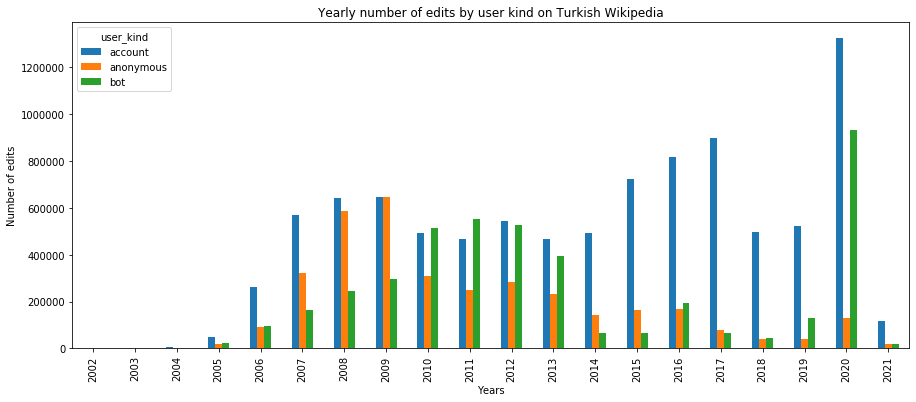

In [61]:
ax = yearly_edits['number_of_edits'].plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)
# Change the axes labels
ax.set_title('Yearly number of edits by user kind on Turkish Wikipedia')
ax.set_xlabel("Years")
ax.set_ylabel("Number of edits")
plt.show()

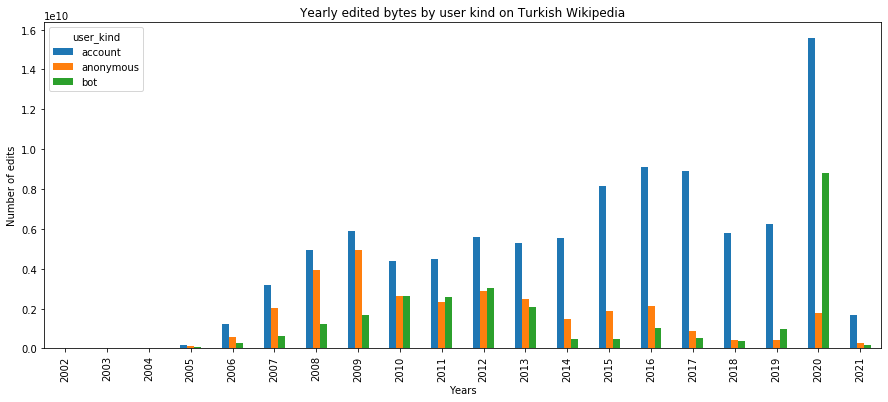

In [62]:
ax = yearly_edits["total_edited_bytes"].plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(15, 6)
# Change the axes labels
ax.set_title('Yearly edited bytes by user kind on Turkish Wikipedia')
ax.set_xlabel("Years")
ax.set_ylabel("Number of edits")
plt.show()

The number of edits seem to tell a different story than the new registrations. The registered editors of wikipedia contributed nearly as much in terms of content and more in terms of edits on 2017 (first year of the block) compared to 2016. A decrease is observed in the subsequent years but the decrease is less significant than the ones we had for the newcomers. For anonymous users the decrease is sharper as we saw in the case of newcomers. The bot activity seems relatively stable and low, and it doesn't seem to be used as a way to combat censorship.

In [63]:
daily_edits[daily_edits['user_kind'] == 'account'].sort_values('number_of_edits', ascending= False).head()

,date,user_kind,number_of_edits,total_edited_bytes
14802,2017-04-26 00:00:00+00:00,account,29441.0,178848137.0
9561,2012-07-14 00:00:00+00:00,account,18014.0,69166247.0
18096,2020-04-28 00:00:00+00:00,account,15499.0,122572087.0
18102,2020-04-30 00:00:00+00:00,account,15157.0,118701565.0
18111,2020-05-03 00:00:00+00:00,account,15001.0,109790144.0


In [64]:
daily_edits[(daily_edits['user_kind'] == 'account') & (daily_edits['date'] < '2017-04-20')].sort_values('number_of_edits', ascending= False).head()

,date,user_kind,number_of_edits,total_edited_bytes
9561,2012-07-14 00:00:00+00:00,account,18014.0,69166247.0
3993,2007-06-15 00:00:00+00:00,account,14320.0,42367213.0
3996,2007-06-16 00:00:00+00:00,account,14236.0,41834877.0
12774,2015-06-20 00:00:00+00:00,account,13164.0,98488883.0
11655,2014-06-12 00:00:00+00:00,account,9752.0,68069455.0


In [65]:
daily_edits = daily_edits[daily_edits['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]

In [66]:
daily_edits['period'] = daily_edits.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

In [67]:
registered_edits = daily_edits[daily_edits['user_kind'] == 'account'][['date', 'period', 'number_of_edits', 'total_edited_bytes']]
anonymous_edits = daily_edits[daily_edits['user_kind'] == 'anonymous'][['date','period', 'number_of_edits', 'total_edited_bytes']]
bot_edits = daily_edits[daily_edits['user_kind'] == 'bot'][['date','period', 'number_of_edits', 'total_edited_bytes']]

In [68]:
registered_edits.corr()

,number_of_edits,total_edited_bytes
number_of_edits,1.000000,0.845523
total_edited_bytes,0.845523,1.000000


In [69]:
anonymous_edits.corr()

,number_of_edits,total_edited_bytes
number_of_edits,1.000000,0.933755
total_edited_bytes,0.933755,1.000000


In [70]:
bot_edits.corr()

,number_of_edits,total_edited_bytes
number_of_edits,1.000000,0.951398
total_edited_bytes,0.951398,1.000000


In [71]:
import matplotlib.dates as mdates

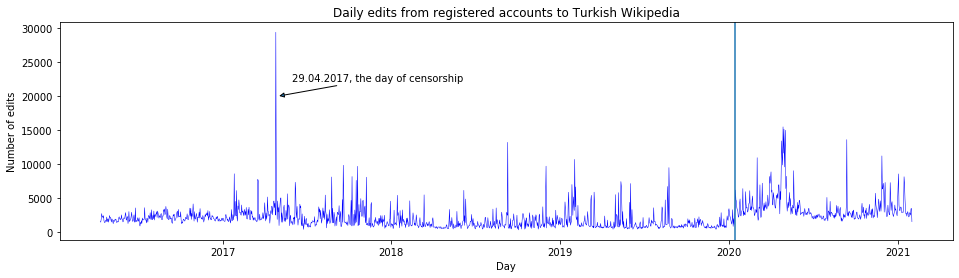

In [72]:
plt.figure(figsize=(16,4)) 
plt.title("Daily edits from registered accounts to Turkish Wikipedia")
plt.plot(registered_edits['date'].values, registered_edits['number_of_edits'], color='blue', lw=0.5)
plt.annotate('29.04.2017, the day of censorship', (mdates.date2num(block_dates[0]), 20000), xytext=(15, 15), textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
plt.ylabel("Number of edits")
plt.xlabel("Day")
plt.axvline(block_dates[1])
plt.show()

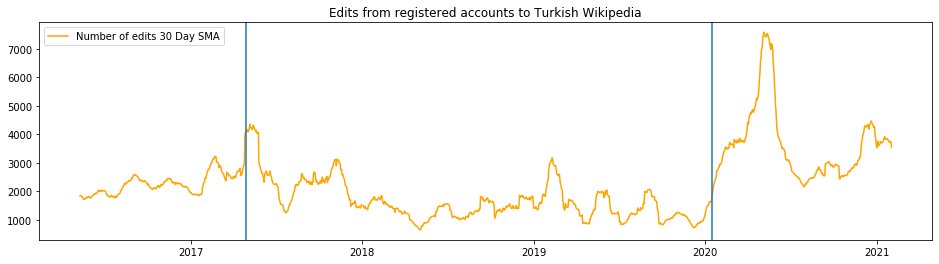

In [73]:
plt.figure(figsize=(16,4))
plt.title("Edits from registered accounts to Turkish Wikipedia")
rolling_mean = registered_edits['number_of_edits'].rolling(window=30).mean()
plt.plot(registered_edits['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color='orange')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

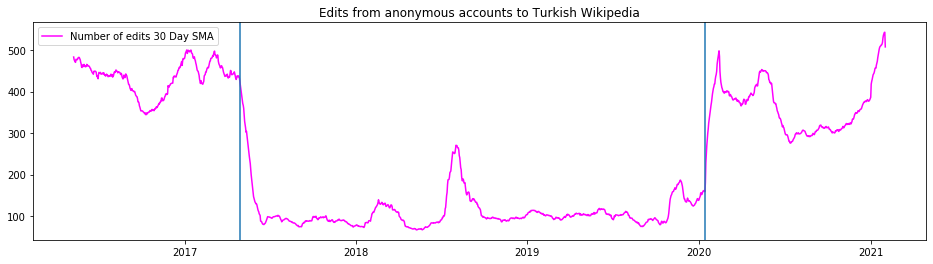

In [74]:
plt.figure(figsize=(16,4))
plt.title("Edits from anonymous accounts to Turkish Wikipedia")
rolling_mean = anonymous_edits['number_of_edits'].rolling(window=30).mean()
plt.plot(anonymous_edits['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

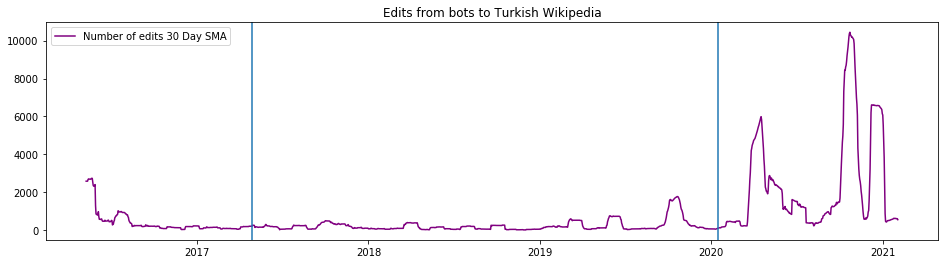

In [75]:
plt.figure(figsize=(16,4))
plt.title("Edits from bots to Turkish Wikipedia")
rolling_mean = bot_edits['number_of_edits'].rolling(window=30).mean()
plt.plot(bot_edits['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color='purple')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

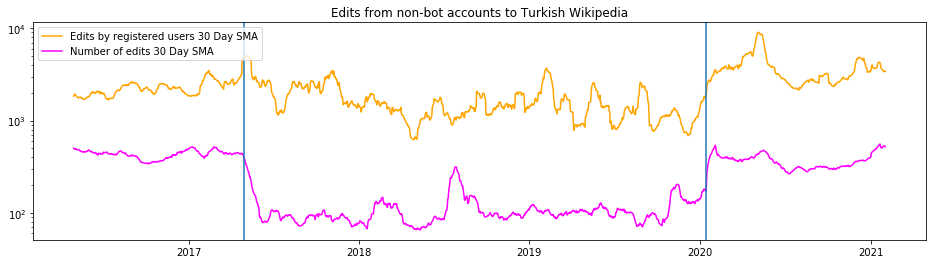

In [76]:
plt.figure(figsize=(16,4))
plt.title("Edits from non-bot accounts to Turkish Wikipedia")
rolling_mean = registered_edits['number_of_edits'].rolling(window=20).mean()
plt.plot(registered_edits['date'].values, rolling_mean, label='Edits by registered users 30 Day SMA', color='orange')
rolling_mean2 = anonymous_edits['number_of_edits'].rolling(window=20).mean()
plt.plot(anonymous_edits['date'].values, rolling_mean2, label='Number of edits 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

Bot activity seems irrelevant. For registered accounts, number of edits doesn't fall as sharply as one can imagine. Anonymous edits drop sharply but recover once the ban is lifted.

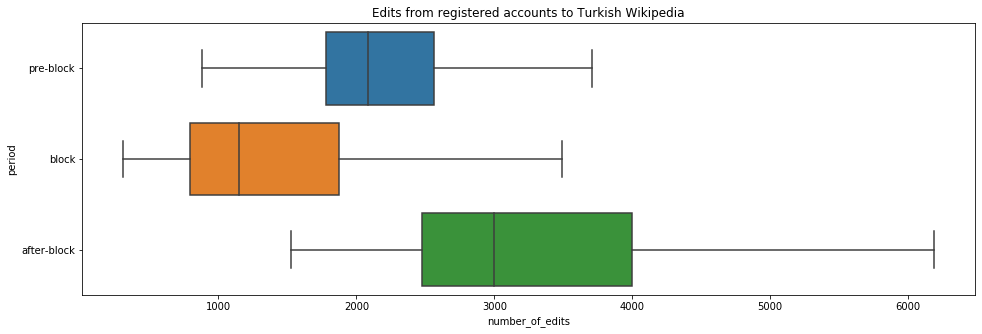

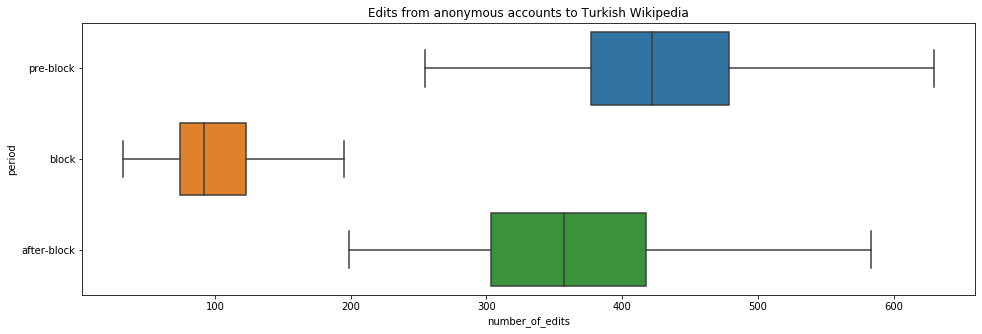

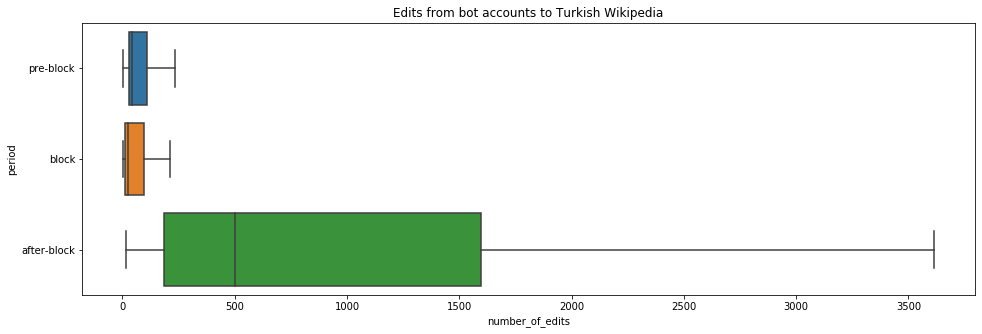

In [77]:
for df, name in [(registered_edits, 'registered'), (anonymous_edits, 'anonymous'), (bot_edits, 'bot')]:
    groups = df.groupby('period')
    periods = pd.concat([pd.DataFrame(x[1]['number_of_edits'].values) for x in groups], axis=1)
    periods = pd.DataFrame(periods)
    periods.columns = range(1,4)
    fig, ax = plt.subplots()
    plt.title(f"Edits from {name} accounts to Turkish Wikipedia")
    fig.set_size_inches(16, 5)
    plt.xlabel('Daily Edits')
    ax = sns.boxplot(y="period", x="number_of_edits", data=df,  showfliers=False)

### Analysis of distinct edited pages

In [78]:
edits.head()

,date,page_id,user_kind,number_of_edits,total_edited_bytes
0,2002-12-05 00:00:00+00:00,5,account,1,24
1,2002-12-05 00:00:00+00:00,2740662,anonymous,2,1819
2,2002-12-13 00:00:00+00:00,2740662,anonymous,2,1781
3,2002-12-16 00:00:00+00:00,2740662,anonymous,2,4766
4,2002-12-17 00:00:00+00:00,2740662,anonymous,1,4310


In [79]:
edited_pages = edits.groupby(['date', 'user_kind'])['page_id'].size()

In [80]:
edited_pages = edited_pages.reset_index()

In [81]:
edited_pages.columns = ['date','user_kind','distinct_page_id']

In [82]:
edited_pages = edited_pages[edited_pages['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]
edited_pages['period'] = edited_pages.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

In [83]:
registered_edited_pages = edited_pages[edited_pages['user_kind'] == 'account']
anonymous_edited_pages = edited_pages[edited_pages['user_kind'] == 'anonymous']
bot_edited_pages = edited_pages[edited_pages['user_kind'] == 'bot']

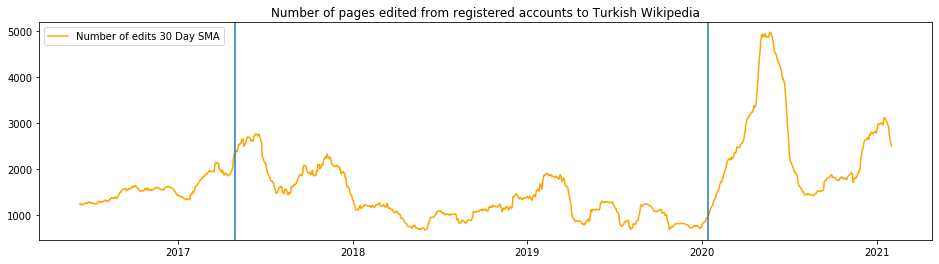

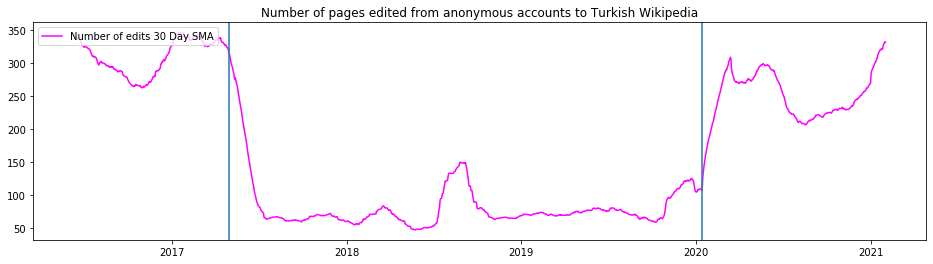

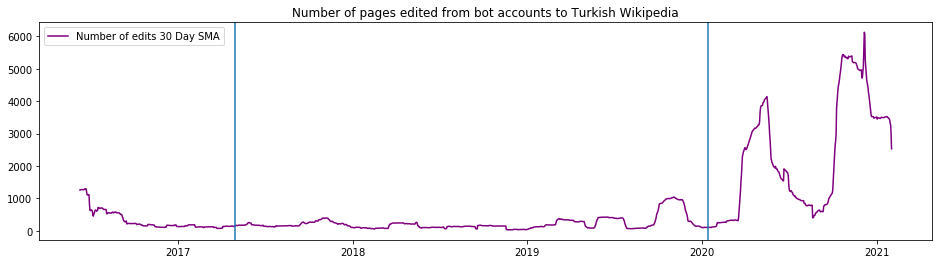

In [84]:
for df, name, color in [(registered_edited_pages, 'registered', 'orange'), (anonymous_edited_pages, 'anonymous', 'magenta'), (bot_edited_pages, 'bot', 'purple')]:
    plt.figure(figsize=(16,4))
    plt.title(f"Number of pages edited from {name} accounts to Turkish Wikipedia")
    rolling_mean = df['distinct_page_id'].rolling(window=60).mean()
    plt.plot(df['date'].values, rolling_mean, label='Number of edits 30 Day SMA', color=color)
    for date in block_dates:
        plt.axvline(date)
    plt.legend(loc='upper left')
    plt.show()

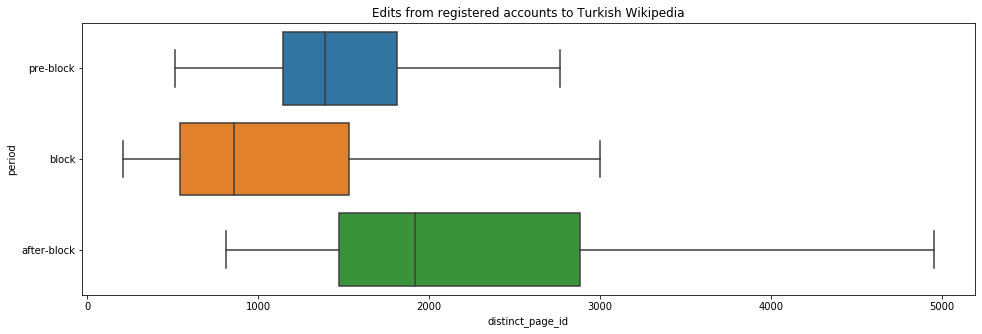

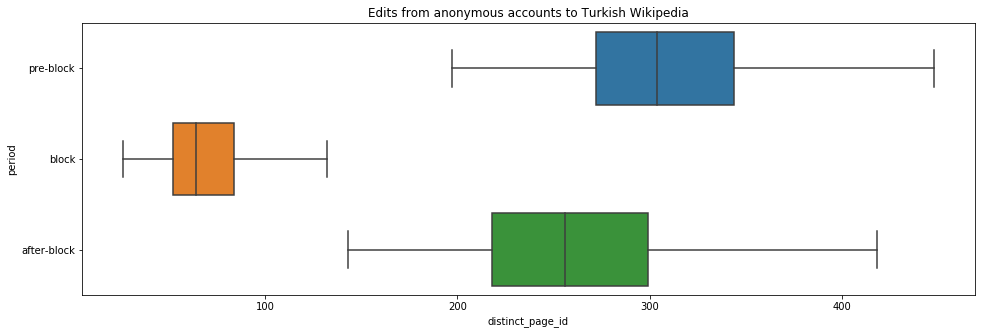

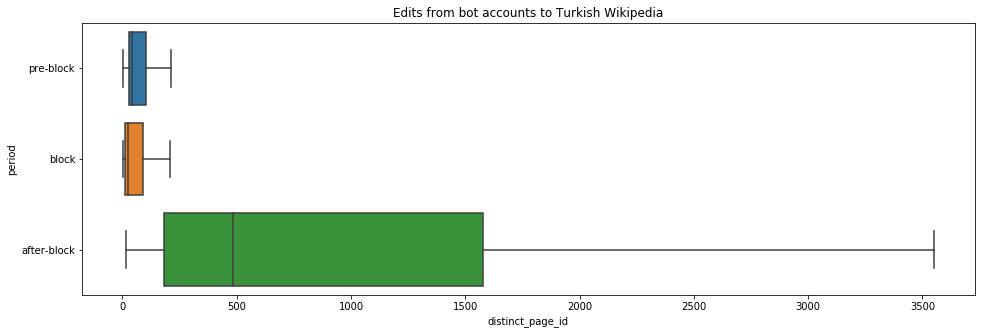

In [85]:
for df, name in [(registered_edited_pages, 'registered'), (anonymous_edited_pages, 'anonymous'), (bot_edited_pages, 'bot')]:
    groups = df.groupby('period')
    periods = pd.concat([pd.DataFrame(x[1]['distinct_page_id'].values) for x in groups], axis=1)
    periods = pd.DataFrame(periods)
    periods.columns = range(1,4)
    fig, ax = plt.subplots()
    plt.title(f"Edits from {name} accounts to Turkish Wikipedia")
    fig.set_size_inches(16, 5)
    plt.xlabel('Daily Edits')
    ax = sns.boxplot(y="period", x="distinct_page_id", data=df,  showfliers=False)

# Reverts (Reverted/Non bot edits)

**Expectations** : Decrease in reverts due to the decrease in the number of newcomers and also due to the threat rigidity: shock -> more cohesion -> less reverts

In [86]:
reverts = pd.read_csv(f'{DATA_PATH}/processed_data/df_reverted.csv')

In [87]:
reverts.columns = ['date','user_kind','number_of_reverts']

In [88]:
reverts['date'] = pd.to_datetime(reverts['date'],   utc = True)

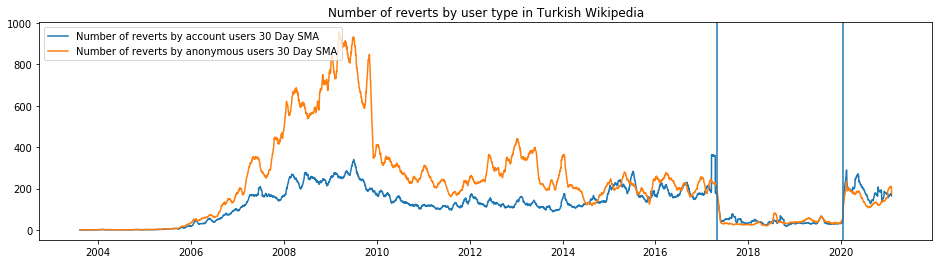

In [89]:
plt.figure(figsize=(16,4))

plt.title(f"Number of reverts by user type in Turkish Wikipedia")
for elem in ['account', 'anonymous']:
    df = reverts[reverts['user_kind'] == elem]
    rolling_mean = df['number_of_reverts'].rolling(window=30).mean()
    plt.plot(df['date'].values, rolling_mean, label=f'Number of reverts by {elem} users 30 Day SMA')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

## Compute revert rate
**Revert Rate** =  number of identity reverts (by humans or bots) by the number of non-bot edits on this given day

In [90]:
daily_non_bot_edits = edits[edits['user_kind'] != 'bot'].groupby(['date'])[['number_of_edits']].sum()

In [91]:
daily_identity_reverts = reverts.groupby(['date'])[['number_of_reverts']].sum()

In [92]:
revert_rate = pd.merge(daily_identity_reverts, daily_non_bot_edits, on = 'date', how = 'outer')

In [93]:
revert_rate['revert_rate'] = revert_rate['number_of_reverts']/revert_rate['number_of_edits']

In [94]:
revert_rate =revert_rate.reset_index()

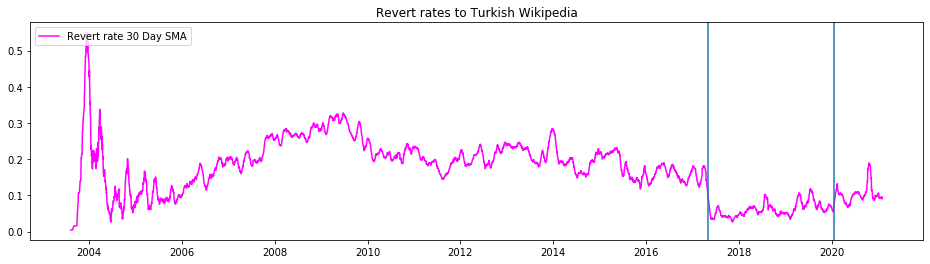

In [95]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
rolling_mean = revert_rate['revert_rate'].rolling(window=30).mean()
plt.plot(revert_rate['date'].values, rolling_mean, label='Revert rate 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [96]:
revert_rate = revert_rate[revert_rate['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]
revert_rate['period'] = revert_rate.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

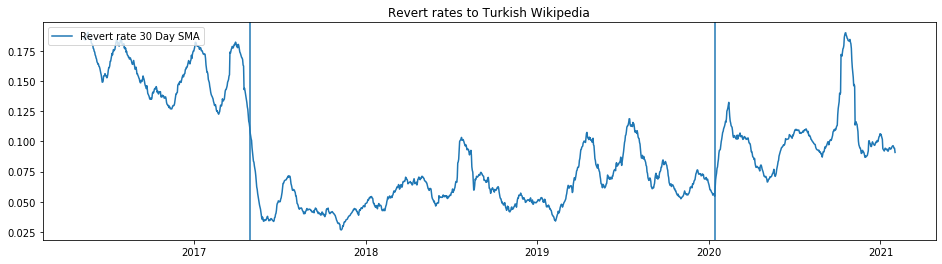

In [97]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
for window in [30]:
    rolling_mean = revert_rate['revert_rate'].rolling(window=window).mean()
    plt.plot(revert_rate['date'].values, rolling_mean, label=f'Revert rate {window} Day SMA')

for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

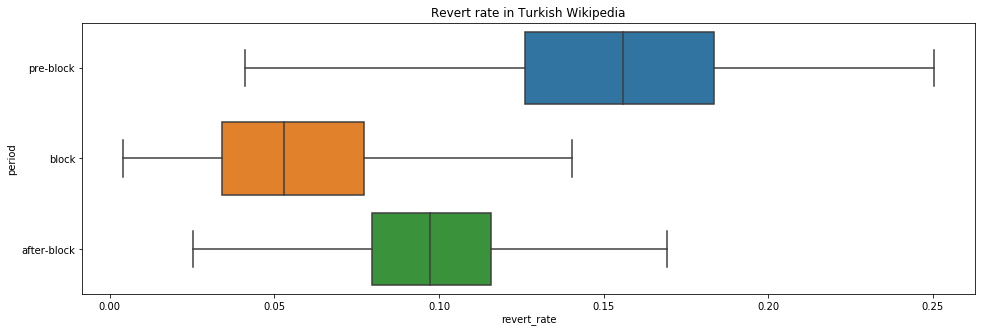

In [98]:
groups = revert_rate.groupby('period')
periods = pd.concat([pd.DataFrame(x[1]['revert_rate'].values) for x in groups], axis=1)
periods = pd.DataFrame(periods)
periods.columns = range(1,4)
fig, ax = plt.subplots()
plt.title(f"Revert rate in Turkish Wikipedia")
fig.set_size_inches(16, 5)
ax = sns.boxplot(y="period", x="revert_rate", data=revert_rate,  showfliers=False)

The median for the revert rate goes down 3x between pre-block and block periods while the number of newcomers goes down by 10x. This could suggest the cohesion effect is real. We have to look into more detail about the newcomers and the number of edits they make and also look at the percent of reverts they receive compared to other users in this period.

# Reverts (Reverts/Number of non bot edits)

**Expectations** : Decrease in reverts due to the decrease in the number of newcomers and also due to the threat rigidity: shock -> more cohesion -> less reverts

In [99]:
reverts = pd.read_csv(f'{DATA_PATH}/processed_data/df_reverts.csv')

In [100]:
reverts.columns = ['date','user_kind','number_of_reverts']

In [101]:
reverts['date'] = pd.to_datetime(reverts['date'],   utc = True)

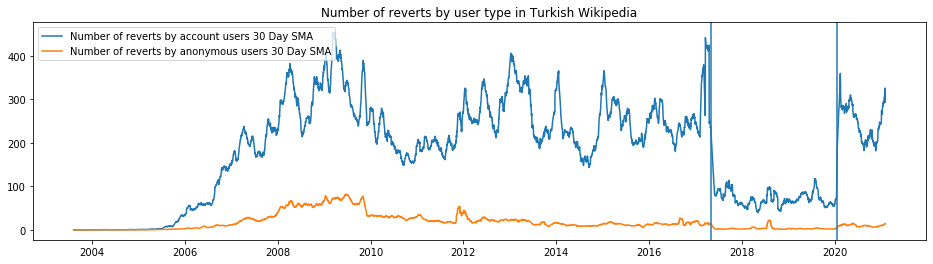

In [102]:
plt.figure(figsize=(16,4))

plt.title(f"Number of reverts by user type in Turkish Wikipedia")
for elem in ['account', 'anonymous']:
    df = reverts[reverts['user_kind'] == elem]
    rolling_mean = df['number_of_reverts'].rolling(window=30).mean()
    plt.plot(df['date'].values, rolling_mean, label=f'Number of reverts by {elem} users 30 Day SMA')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

## Compute revert rate
**Revert Rate** =  number of identity reverts (by humans or bots) by the number of non-bot edits on this given day

In [103]:
daily_non_bot_edits = edits[edits['user_kind'] != 'bot'].groupby(['date'])[['number_of_edits']].sum()

In [104]:
daily_identity_reverts = reverts.groupby(['date'])[['number_of_reverts']].sum()

In [105]:
revert_rate = pd.merge(daily_identity_reverts, daily_non_bot_edits, on = 'date', how = 'outer')

In [106]:
revert_rate['revert_rate'] = revert_rate['number_of_reverts']/revert_rate['number_of_edits']

In [107]:
revert_rate =revert_rate.reset_index()

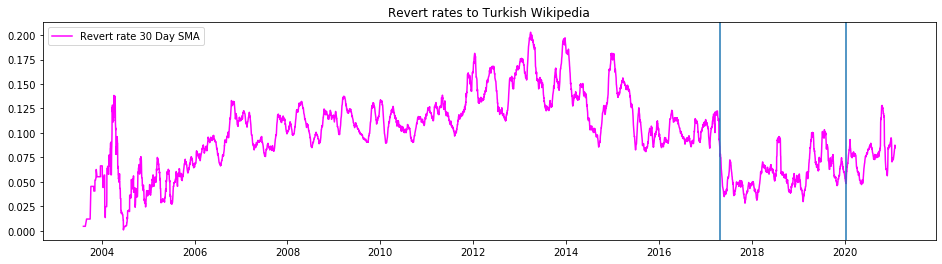

In [108]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
rolling_mean = revert_rate['revert_rate'].rolling(window=30).mean()
plt.plot(revert_rate['date'].values, rolling_mean, label='Revert rate 30 Day SMA', color='magenta')
for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

In [109]:
revert_rate = revert_rate[revert_rate['date'] >= block_dates[0]-pd.Timedelta(days=days_after_block)]
revert_rate['period'] = revert_rate.apply(lambda row: 'pre-block' if row['date'] < block_dates[0] else 'block' if not row['date'] >= block_dates[1] else 'after-block', axis=1)

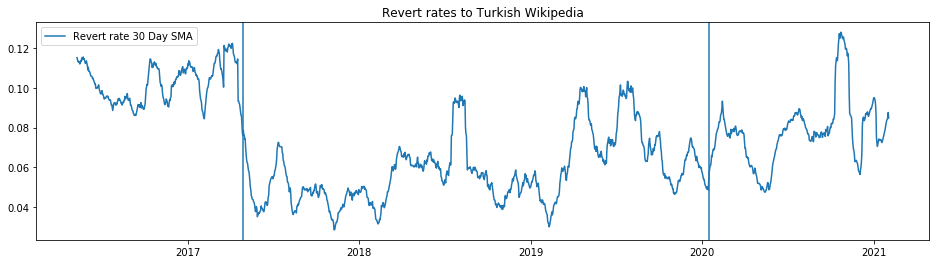

In [110]:
plt.figure(figsize=(16,4))
plt.title("Revert rates to Turkish Wikipedia")
for window in [30]:
    rolling_mean = revert_rate['revert_rate'].rolling(window=window).mean()
    plt.plot(revert_rate['date'].values, rolling_mean, label=f'Revert rate {window} Day SMA')

for date in block_dates:
    plt.axvline(date)
plt.legend(loc='upper left')
plt.show()

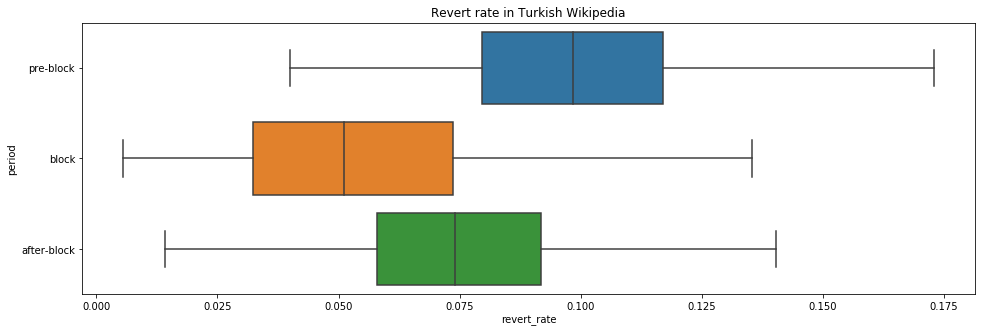

In [111]:
groups = revert_rate.groupby('period')
periods = pd.concat([pd.DataFrame(x[1]['revert_rate'].values) for x in groups], axis=1)
periods = pd.DataFrame(periods)
periods.columns = range(1,4)
fig, ax = plt.subplots()
plt.title(f"Revert rate in Turkish Wikipedia")
fig.set_size_inches(16, 5)
ax = sns.boxplot(y="period", x="revert_rate", data=revert_rate,  showfliers=False)

The median for the revert rate goes down 3x between pre-block and block periods while the number of newcomers goes down by 10x. This could suggest the cohesion effect is real. We have to look into more detail about the newcomers and the number of edits they make and also look at the percent of reverts they receive compared to other users in this period.